In [14]:
import os
import timeit
import time
import numpy as np
from collections import OrderedDict
from pprint import pformat
from tqdm import tqdm
#from google.colab import drive
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data.sampler import *
from torchvision import transforms, datasets
import torch.optim.lr_scheduler as lr_anneal
from torch.utils.data import Subset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
torch.multiprocessing.set_sharing_strategy('file_system')
cudnn.benchmark = True

import matplotlib.pyplot as plt


In [15]:
# -*- coding: utf-8 -*-


# Don't edit this cell
import os
import timeit
import time
import numpy as np
from collections import OrderedDict
from pprint import pformat
from tqdm import tqdm
#from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data.sampler import *
from torchvision import transforms, datasets
import torch.optim.lr_scheduler as lr_anneal
from torch.utils.data import Subset

torch.multiprocessing.set_sharing_strategy('file_system')
cudnn.benchmark = True
Epoch_loss = []
# TODO: Main model definition + any utilities such as weight initialization or custom layers, ADD DROPOUT, BATCHNORM, SKIP CONNECTION,
class Net(nn.Module):
    def __init__(self):
      super(Net,self).__init__()
      self.pool = nn.MaxPool2d(2,2)
      self.skip = nn.Identity()

      self.conv11   = nn.Conv2d(3,16,3,padding=1)
      self.batchnorm16 = nn.BatchNorm2d(16)
      #set
      self.downsample1 = nn.Conv2d(16,32,1,stride = 2)
      self.conv12   = nn.Conv2d(16,32,3,padding=1)

      self.conv21   = nn.Conv2d(32,32,3,padding=1)
      #+
      #set
      self.downsample2 = nn.Conv2d(32,64,1,stride = 2)
      self.batchnorm32 = nn.BatchNorm2d(32)
      self.conv22   = nn.Conv2d(32,64,3,padding=1)

      self.conv31   = nn.Conv2d(64,64,3,padding=1)
      #+
      self.batchnorm64 = nn.BatchNorm2d(64)
      self.conv32   = nn.Conv2d(64,128,3,padding=1)
      self.batchnorm128 = nn.BatchNorm2d(128)
      self.fc1    = nn.Linear(128*4*4,2*2*128)
      self.fc2    = nn.Linear(2*2*128,128)
      self.fc3    = nn.Linear(128,10)
      self.fcout = nn.Linear(128*4*4,10)
    def forward(self,x):
      '''
      -> Use increasing dropout 
      
      -> CNN structure for each block is like
        _. conv => batch => conv => pool =>dropout
        _. With skip connection every two conv

      -> Three fully connected layers at the end
        _. With drop out
      '''
      '''
      first cnn block
      '''
      x = F.relu(self.conv11(x))
      #batch normalization
      x = self.batchnorm16(x)
      #initial for skip connection
      skip1 = x
      skip1 = self.downsample1(skip1)
      x = F.relu(self.conv12(x))
      #maxPooling
      x = self.pool(x)###
      #dropout
      x = F.dropout(x,p = 0.3)###


      '''
      second cnn block
      '''
      x = F.relu(self.conv21(x))
      #skip connection
      x = x+skip1
      x = self.batchnorm32(x)
      skip2 = x
      ship2 = self.downsample2(skip2)
      #print("skip2 shape",skip2.shape)
      x = F.relu(self.conv22(x))
      x = self.pool(x)#may pool###
      x = F.dropout(x,p = 0.4)###


      '''
      third cnn block
      '''
      x = F.relu(self.conv31(x))
      #print("shape is",x.shape)
      #x = x+skip2 
      x = self.batchnorm64(x)
      x = F.relu(self.conv32(x))
      x = self.batchnorm128(x)
      x = self.pool(x)
      x = F.dropout(x,p = 0.5)


      '''
      Flatten to fully connected layers
      '''
      #print(x.shape)
      #flatten the layers
      x = x.view(-1,128*4*4)
      #First fully connected layer
      x = self.fcout(F.relu(x))
      '''
      x = F.relu(self.fc1(x))
      x = F.dropout(x,p = 0.5)
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      '''
      return x

cnn = Net()

# TODO: Cifar-10 dataloading
def load_data(config):
    """
    Load cifar-10 dataset using torchvision, take the last 5k of the training data to be validation data
    """
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    cifar10_training = datasets.CIFAR10(root='./CIFAR10_dataset', train=True,
                      download=True, transform=transform_train)
    # training set
    cifar10_training_set = Subset(
        cifar10_training, range(len(cifar10_training)-5000))
    # validation set
    cifar10_validation_set = Subset(
        cifar10_training, range(len(cifar10_training)-5000,len(cifar10_training)))
    # test set
    cifar10_test_set = datasets.CIFAR10(root='./CIFAR10_dataset', train=False,
                      download=True, transform=transform_test)
    #in config
    batch_size_train = config['batch_size']
    

    #dataloaders
    train_dataloader = torch.utils.data.DataLoader(
            cifar10_training_set, batch_size=batch_size_train, shuffle=True, num_workers=2)
    #
    valid_dataloader = torch.utils.data.DataLoader(
        cifar10_validation_set, batch_size=batch_size_train, shuffle=True, num_workers=2)\
    #
    test_dataloader = torch.utils.data.DataLoader(
        cifar10_test_set, batch_size=1, shuffle=True, num_workers=2)

    return train_dataloader, valid_dataloader, test_dataloader

# TODO : Main trainig + validation, returns the final model, save your best checkpoint based on the best validation accuracy
def train(trainloader, valid_dataloader, device, config):
    epoch_loss = []
    
    #hyperparameters
    epoch = config['num_epochs']
    lr = config['lr']
    momentum = config['momentum']
    decay = config['regular_constant']
    batch_size = config['batch_size']
    cnn.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(),
            lr=lr,weight_decay=decay)
    #learning rate annealing
    scheduler = lr_anneal.StepLR(optimizer,step_size=15,gamma=0.1)
    #initialize a accuracy to be saved for 
    best_acc=0.60
    #training
    for u in range(epoch):
      cnn.train()
      total_loss = 0
      for batch_idx,(data,target) in tqdm(enumerate(trainloader),total=math.ceil(45000/batch_size),position=0,leave=True):
        data  = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = cnn(data).to(device)
        
        loss = criterion(output,target)
        total_loss += loss        
        loss.backward()
        optimizer.step()
      Epoch_loss.append(total_loss.item())

      print("epoch version: ",(u+1))


      
      #validating
      cnn.eval()
      
      mean_acc = 0
      total = 0
      correct = 0
      #validate every 3 epoch
      if (u+1)%3 ==0:
        with torch.no_grad():
          for data,target in valid_dataloader:
            data = data.to(device)
            target = target.to(device)
            output = cnn(data).to(device)
            _,predicted = torch.max(output,dim=1)
            total += target.size(0)
            correct += (predicted==target).sum().item()
    # your code here
      if total!=0:
        mean_acc = correct/total
        print(mean_acc)
      
      #save accuracy to save best model 
      if mean_acc >0.60 and mean_acc>best_acc:
        print("=================================="\
                    "Current Model Saved"\
              "==================================")
        
        #save model to file
        if not os.path.isdir('checkpoint'):
          os.mkdir('checkpoint')
        torch.save(cnn.state_dict(), './checkpoint/ckpt.pth')
        best_acc = mean_acc
      
      #lr anneal
      scheduler.step()
      
    return cnn,epoch_loss

def save_model_colab_for_submission(model):  # if you are running on colab
  drive.mount('/content/gdrive/', force_remount=True)
  torch.save(model.to(torch.device("cpu")), '/content/gdrive/My Drive/model.pt') # you will find the model in your home drive
  
def save_model_local_for_submission(model):  # if you are running on your local machine
  torch.save(model.to(torch.device("cpu")), 'model.pt')

#TODO: Implement testing
def test(net, testloader, device):
    correct = 0
    total = 0
    ###
    net.eval()

    with torch.no_grad():
      for data,target  in testloader:
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        _,predicted = torch.max(output,dim=1)

        total += target.size(0)
        correct +=(predicted==target).sum().item()

    return 100.*correct/total, correct, total

def run():
  # set parameters cifar10
  config = {
        'lr': 0.01,
        'num_epochs': 70,
        'batch_size': 64,
        'num_classes': 10,
        'momentum':0.99,
        'regular_constant': 3e-3,
       }
    
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  train_dataloader, valid_dataloader, test_dataloader = load_data(config)
  
  model,losses = train(train_dataloader, valid_dataloader, device, config)
  Epoch_loss = losses
  # Testing and saving for submission
  device = torch.device("cuda")
  
  assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
  checkpoint = torch.load('./checkpoint/ckpt.pth')
  model.load_state_dict(checkpoint)
  
  model.eval()
  
  start_time = timeit.default_timer()
  test_acc, test_correct, test_total = test(model.to(device), test_dataloader, device)
  end_time = timeit.default_timer()
  test_time = (end_time - start_time)
  
  #save_model_colab_for_submission(model)
  print(losses)
  return test_acc, test_correct

"""Main loop. Run time and total score will be shown below."""

# Don't edit this cell


def main():
    
  accuracy, correct = run()
  
  
  
  result = OrderedDict(correct=correct, accuracy=accuracy,
                        
                        )
  
  with open('result.txt', 'w') as f:
      f.writelines(pformat(result, indent=4))
  print("\nResult:\n", pformat(result, indent=4))


main()

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 704/704 [00:19<00:00, 35.47it/s]

epoch version:  1



100%|██████████| 704/704 [00:19<00:00, 36.03it/s]

epoch version:  2



100%|██████████| 704/704 [00:19<00:00, 36.20it/s]

epoch version:  3


0.3936


100%|██████████| 704/704 [00:19<00:00, 36.21it/s]

epoch version:  4



100%|██████████| 704/704 [00:19<00:00, 36.37it/s]


epoch version:  5


100%|██████████| 704/704 [00:19<00:00, 36.68it/s]

epoch version:  6


0.3886


100%|██████████| 704/704 [00:19<00:00, 36.67it/s]

epoch version:  7



100%|██████████| 704/704 [00:19<00:00, 36.71it/s]

epoch version:  8



100%|██████████| 704/704 [00:19<00:00, 36.59it/s]

epoch version:  9


0.415


100%|██████████| 704/704 [00:19<00:00, 36.77it/s]

epoch version:  10



100%|██████████| 704/704 [00:19<00:00, 35.93it/s]

epoch version:  11



100%|██████████| 704/704 [00:19<00:00, 36.12it/s]

epoch version:  12


0.4502


100%|██████████| 704/704 [00:19<00:00, 36.51it/s]

epoch version:  13



100%|██████████| 704/704 [00:18<00:00, 37.46it/s]

epoch version:  14



100%|██████████| 704/704 [00:18<00:00, 37.66it/s]

epoch version:  15


0.4194


100%|██████████| 704/704 [00:18<00:00, 37.72it/s]

epoch version:  16



100%|██████████| 704/704 [00:18<00:00, 38.24it/s]

epoch version:  17



100%|██████████| 704/704 [00:18<00:00, 37.83it/s]

epoch version:  18


0.6128
==================================Current Model Saved==================================


100%|██████████| 704/704 [00:18<00:00, 38.76it/s]

epoch version:  19



100%|██████████| 704/704 [00:17<00:00, 39.18it/s]

epoch version:  20



100%|██████████| 704/704 [00:17<00:00, 39.31it/s]

epoch version:  21


0.6392
==================================Current Model Saved==================================


100%|██████████| 704/704 [00:17<00:00, 39.16it/s]

epoch version:  22



100%|██████████| 704/704 [00:17<00:00, 39.43it/s]

epoch version:  23



100%|██████████| 704/704 [00:18<00:00, 39.05it/s]

epoch version:  24


0.6418
==================================Current Model Saved==================================


100%|██████████| 704/704 [00:17<00:00, 39.53it/s]

epoch version:  25



100%|██████████| 704/704 [00:18<00:00, 39.06it/s]

epoch version:  26



100%|██████████| 704/704 [00:17<00:00, 39.16it/s]

epoch version:  27


0.6592
==================================Current Model Saved==================================


100%|██████████| 704/704 [00:17<00:00, 39.20it/s]

epoch version:  28



100%|██████████| 704/704 [00:17<00:00, 39.72it/s]

epoch version:  29



100%|██████████| 704/704 [00:17<00:00, 39.34it/s]

epoch version:  30


0.6754
==================================Current Model Saved==================================


100%|██████████| 704/704 [00:17<00:00, 39.25it/s]

epoch version:  31



100%|██████████| 704/704 [00:17<00:00, 39.28it/s]


epoch version:  32


100%|██████████| 704/704 [00:17<00:00, 39.65it/s]

epoch version:  33


0.7046
==================================Current Model Saved==================================


100%|██████████| 704/704 [00:18<00:00, 39.01it/s]

epoch version:  34



100%|██████████| 704/704 [00:19<00:00, 35.78it/s]

epoch version:  35



100%|██████████| 704/704 [00:19<00:00, 35.47it/s]

epoch version:  36


0.7004


100%|██████████| 704/704 [00:20<00:00, 35.17it/s]

epoch version:  37



100%|██████████| 704/704 [00:19<00:00, 36.53it/s]


epoch version:  38


100%|██████████| 704/704 [00:19<00:00, 36.40it/s]

epoch version:  39


0.7248
==================================Current Model Saved==================================


100%|██████████| 704/704 [00:19<00:00, 36.07it/s]


epoch version:  40


100%|██████████| 704/704 [00:19<00:00, 36.32it/s]

epoch version:  41



100%|██████████| 704/704 [00:19<00:00, 36.37it/s]

epoch version:  42


0.725
==================================Current Model Saved==================================


100%|██████████| 704/704 [00:20<00:00, 34.91it/s]

epoch version:  43



100%|██████████| 704/704 [00:19<00:00, 35.57it/s]

epoch version:  44



100%|██████████| 704/704 [00:20<00:00, 35.17it/s]

epoch version:  45


0.7238


100%|██████████| 704/704 [00:20<00:00, 34.48it/s]

epoch version:  46



100%|██████████| 704/704 [00:20<00:00, 34.66it/s]


epoch version:  47


100%|██████████| 704/704 [00:20<00:00, 34.43it/s]

epoch version:  48


0.7322
==================================Current Model Saved==================================


100%|██████████| 704/704 [00:20<00:00, 34.05it/s]

epoch version:  49



100%|██████████| 704/704 [00:20<00:00, 34.17it/s]

epoch version:  50



100%|██████████| 704/704 [00:19<00:00, 35.84it/s]

epoch version:  51


0.7244


100%|██████████| 704/704 [00:19<00:00, 35.39it/s]


epoch version:  52


100%|██████████| 704/704 [00:19<00:00, 35.54it/s]

epoch version:  53



100%|██████████| 704/704 [00:19<00:00, 35.46it/s]

epoch version:  54


0.728


100%|██████████| 704/704 [00:21<00:00, 33.46it/s]

epoch version:  55



100%|██████████| 704/704 [00:21<00:00, 33.18it/s]


epoch version:  56


100%|██████████| 704/704 [00:20<00:00, 34.18it/s]

epoch version:  57


0.7276


100%|██████████| 704/704 [00:20<00:00, 34.78it/s]

epoch version:  58



100%|██████████| 704/704 [00:19<00:00, 35.27it/s]


epoch version:  59


100%|██████████| 704/704 [00:20<00:00, 35.12it/s]

epoch version:  60


0.7374
==================================Current Model Saved==================================


100%|██████████| 704/704 [00:20<00:00, 34.97it/s]

epoch version:  61



100%|██████████| 704/704 [00:20<00:00, 34.69it/s]

epoch version:  62



100%|██████████| 704/704 [00:20<00:00, 35.15it/s]

epoch version:  63


0.7308


100%|██████████| 704/704 [00:19<00:00, 35.98it/s]

epoch version:  64



100%|██████████| 704/704 [00:19<00:00, 36.71it/s]


epoch version:  65


100%|██████████| 704/704 [00:19<00:00, 36.64it/s]

epoch version:  66


0.7308


100%|██████████| 704/704 [00:18<00:00, 37.07it/s]

epoch version:  67



100%|██████████| 704/704 [00:18<00:00, 37.16it/s]


epoch version:  68


100%|██████████| 704/704 [00:19<00:00, 36.45it/s]

epoch version:  69


0.7282


100%|██████████| 704/704 [00:20<00:00, 35.12it/s]

epoch version:  70


[]

Result:
 OrderedDict([('correct', 7250), ('accuracy', 72.5)])


Files already downloaded and verified


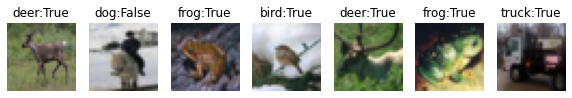

In [41]:


test_transforms = transforms.Compose([
        transforms.ToTensor(),
        
    ])
data = datasets.CIFAR10(root='./CIFAR10_dataset', train=False,
                      download=True, transform=test_transforms)
classes = data.classes
def predict_image(image):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device('cpu')
    test_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = cnn(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_random_images(num):
    #data = datasets.ImageFolder(train_dataloader, transform=test_transforms)
    #data = datasets.CIFAR10(root='./CIFAR10_dataset', train=False,
                      #download=True, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

to_pil = transforms.ToPILImage()
images, labels = get_random_images(7)
fig=plt.figure(figsize=(10,10))
for i in range(len(images)):
    image = to_pil(images[i])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), i+1)
    res = int(labels[i]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [21]:
Epoch_loss= np.array((Epoch_loss))*0.01


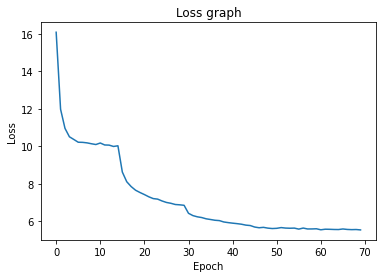

In [44]:
plt.axes(ylabel='Loss',xlabel='Epoch',title='Loss graph')
plt.plot(Epoch_loss)